# 🧠 Customer Churn Prediction (ML Project - Part B)

## 1. 📘 Overview
Customer churn is when a customer discontinues using a company’s product or service. Predicting churn helps businesses take proactive steps to retain customers.

This notebook walks through:
- Data preprocessing
- Model training & tuning
- Evaluation using metrics
- Business insights

---

## 2. ❓ Problem Statement

We aim to build a classification model that predicts whether a customer will churn based on:
- Demographics
- Account tenure
- Subscription services
- Billing behavior

This will help businesses improve customer retention and reduce revenue loss.


## 3. 📦 Load Required Libraries and Data

In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Load dataset
df = pd.read_csv("Customer Churn Prediction.csv")
df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 4. 🧹 Data Cleaning & Preprocessing

In [18]:
# Drop customerID
df.drop('customerID', axis=1, inplace=True)

# Convert TotalCharges to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

# Convert Churn to binary
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Check data types & missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


## 5. 📊 Exploratory Data Analysis

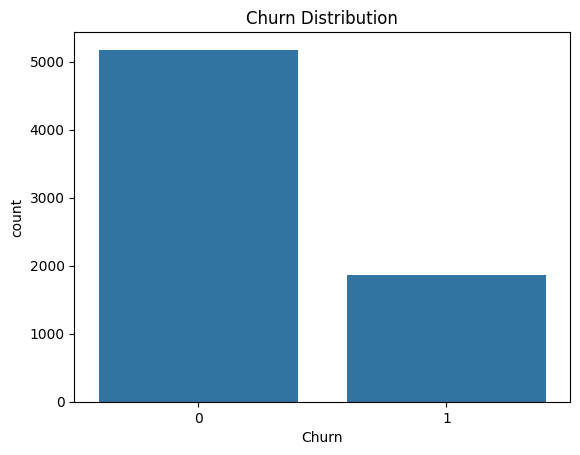

In [20]:
# Class distribution
sns.countplot(x='Churn', data=df)
plt.title("Churn Distribution")
plt.show()

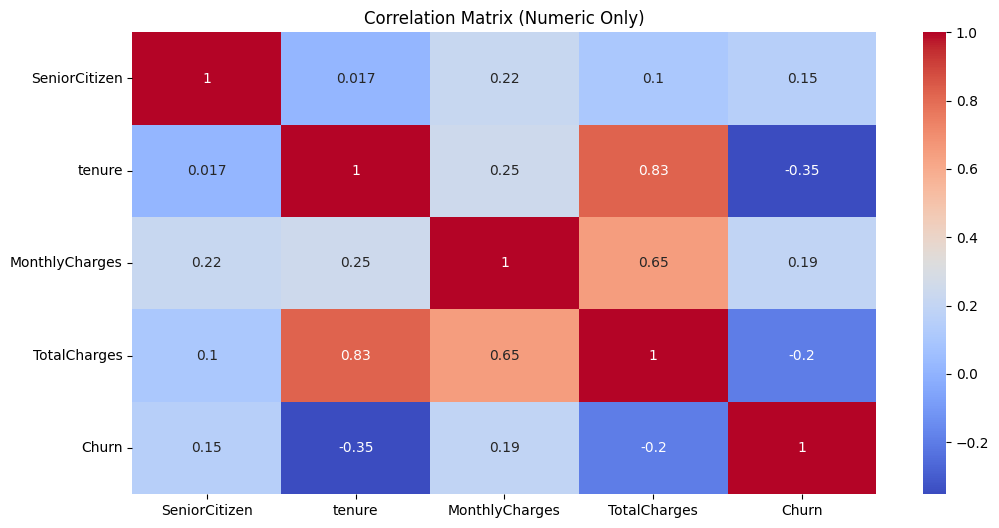

In [21]:
# Only select numeric columns for correlation
numeric_df = df.select_dtypes(include=['int64', 'float64'])
plt.figure(figsize=(12, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix (Numeric Only)")
plt.show()


## 6. 🔠 Encoding & Feature Scaling

In [22]:
# Encode categorical variables
cat_cols = df.select_dtypes(include='object').columns.tolist()
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

# Scale numerical features
scaler = StandardScaler()
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
df[num_cols] = scaler.fit_transform(df[num_cols])

df.head()


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,-1.277445,0,1,0,0,2,0,0,0,0,0,1,2,-1.160323,-0.994242,0
1,1,0,0,0,0.066327,1,0,0,2,0,2,0,0,0,1,0,3,-0.259629,-0.173244,0
2,1,0,0,0,-1.236724,1,0,0,2,2,0,0,0,0,0,1,3,-0.362660,-0.959674,1
3,1,0,0,0,0.514251,0,1,0,2,0,2,2,0,0,1,0,0,-0.746535,-0.194766,0
4,0,0,0,0,-1.236724,1,0,1,0,0,0,0,0,0,0,1,2,0.197365,-0.940470,1


## 7. 🧪 Train-Test Split

In [23]:
X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

X_train.shape, X_test.shape

((4930, 19), (2113, 19))

## 8. 🤖 Model Training (Random Forest)

In [31]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

## 9. 📈 Model Evaluation

 print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


## 10. 🔍 Single Sample Prediction

In [33]:
sample = X_test.iloc[[0]]
rf_model.predict(sample)

array([1])

## 11. 💼 Insights & Recommendations

### 🔎 Key Observations:
- Month-to-month contracts, electronic check payments, and lack of tech support are associated with higher churn.
- Long tenure, fiber optic internet, and bundled services reduce churn.

### 🧩 Business Recommendations:
- Offer incentives to switch from month-to-month to yearly contracts.
- Promote tech support & online security as value-added services.
- Target at-risk customers using this model and provide retention offers.